In [1]:
import sys
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files

In [102]:
#1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tk = th.Thicket.from_caliperreader(glob("<PATH>"))
tk.show_metric_columns()
print(tk.tree(metric_column='Avg time/rank'))

(2/2) Creating Thicket: 100%|██████████| 266/266 [00:01<00:00, 137.31it/s]


  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

0.077 MPI_Comm_dup
0.000 MPI_Finalize
0.000 MPI_Finalized
0.000 MPI_Initialized
0.272 main
├─ 0.202 comm
│  ├─ 0.129 comm_large
│  │  ├─ 0.082 MPI_Recv
│  │  └─ 0.045 MPI_Send
│  └─ 0.072 comm_small
│     ├─ 0.069 MPI_Bcast
│     └─ 0.003 MPI_Gather
├─ 0.061 comp
│  ├─ 0.061 comp_large
│  └─ 0.000 comp_small
├─ 0.007 correctness_check
│  └─ 0.006 comm
│     └─ 0.006 comm_small
│        ├─ 0.006 MPI_Recv
│        └─ 0.000 MPI_Send
└─ 0.002 data_init_runtime
   ├─ 0.001 data_init_runtime
   └─ nan data_perturbed_init_runtime
      └─ nan data_init_runtime

Legend (Metric: Avg time/rank Min: 0.00 Max: 0.27 indices: {'profile': 3630412})
█ 0.24 - 0.27
█ 0.19 - 0.24
█ 0.14 - 0.19
█ 0.08 - 0.14
█ 0.03 - 0.08
█ 0.00 - 0.03

name User code    ◀  Only in left graph    ▶  Only in right graph



View Calltree

In [21]:
tk.show_metric_columns()

['Min time/rank',
 'Max time/rank',
 'Calls/rank (avg)',
 'Calls/rank (min)',
 'Variance time/rank',
 'Min time/rank (exc)',
 'Max time/rank (exc)',
 'Avg time/rank (exc)',
 'Calls/rank (max)',
 'Total time (exc)',
 'Total time',
 'Avg time/rank',
 'Calls/rank (total)']

Group Performance data by `matrix_size` in the Thicket metadata table.

In [103]:
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("input_size")
tk.metadata_column_to_perfdata("input_type")
tk.dataframe = tk.dataframe.reset_index().set_index(["input_size"]).sort_index()

tk.dataframe.head()

,node,profile,nid,spot.channel,Min time/rank,Max time/rank,Avg time/rank,Total time,Variance time/rank,Calls/rank (min),Calls/rank (avg),Calls/rank (max),Calls/rank (total),Min time/rank (exc),Max time/rank (exc),Avg time/rank (exc),Total time (exc),name,num_procs,input_type
input_size,,,,,,,,,,,,,,,,,,,,
65536,"{'name': 'MPI_Send', 'type': 'function'}",3282642745,13.0,regionprofile,0.001145,0.344664,0.002823,0.722615,0.000458,255.0,255.996094,256.0,65535.0,0.001145,0.344664,0.002823,0.722615,MPI_Send,256,Sorted
65536,"{'name': 'MPI_Gather', 'type': 'function'}",769660962,6.0,regionprofile,0.000071,0.071077,0.002830,0.181101,0.000099,1.0,1.000000,1.0,64.0,0.000071,0.071077,0.002830,0.181101,MPI_Gather,64,Sorted
65536,"{'name': 'comm_large', 'type': 'function'}",2223146385,11.0,regionprofile,0.001965,0.004686,0.003727,0.029817,0.000001,1.0,1.000000,1.0,8.0,0.000148,0.000445,0.000321,0.002570,comm_large,8,ReverseSorted
65536,"{'name': 'MPI_Send', 'type': 'function'}",980183362,26.0,regionprofile,0.000005,0.000010,0.000008,0.000115,0.000000,1.0,1.000000,1.0,15.0,0.000005,0.000010,0.000008,0.000115,MPI_Send,16,Sorted
65536,"{'name': 'data_init_runtime', 'type': 'function'}",291094813,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,128,Sorted


In [92]:
# Define common variables
processes = [2, 4, 8, 16, 32, 64, 128, 256, 1024]
threads =  [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
input_sizes = [16, 18, 20, 22, 24, 26, 28]
input_types = ["Sorted", "1_perc_perturbed", "Random", "ReverseSorted"]

In [8]:
# Change font size for all plots
plt.rcParams.update({"font.size": 20})

In [134]:
def plot_mpl(df, title, xlabel, ylabel):
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(
        df,
        marker='o',
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(["2^16", "2^18", "2^20", "2^22", "2^24", "2^26", "2^28"])
    plt.xscale("log", base=2)
    plt.xticks(threads)
    ax.set_xticklabels(threads)
    ax.set_ylim(bottom=0, top=None)
    plt.show()
    return fig, ax

num_procs          2         4          8         16         32         64  \
input_size                                                                   
65536       0.008428  0.008846   0.013244   0.017856   0.025902   0.080008   
262144      0.005045  0.009606   0.027528   0.034109   0.049522   0.154979   
1048576     0.013471  0.047245   0.051557   0.097259   0.130390   0.214053   
4194304     0.018063  0.085116   0.230216   0.227205   0.390263   0.657141   
16777216    0.206001  0.630967   1.007096   1.050158   1.689360   2.630096   
67108864    0.985814  1.065484   2.456787   4.045878   5.378171  14.755638   
268435456   0.970546  5.684790  14.393760  18.958103  59.182591  74.952363   

num_procs         128         256         512        1024  
input_size                                                 
65536        0.101412    0.364813    0.762458    2.561456  
262144       0.155217    1.257379    1.016644         NaN  
1048576      0.580033    0.826550    1.881276    4.768388

C:\Users\redky\AppData\Local\Temp\ipykernel_42036\2424531023.py:7: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.pivot_table(index = 'input_size', columns='num_procs',values='Avg time/rank', aggfunc = sum)


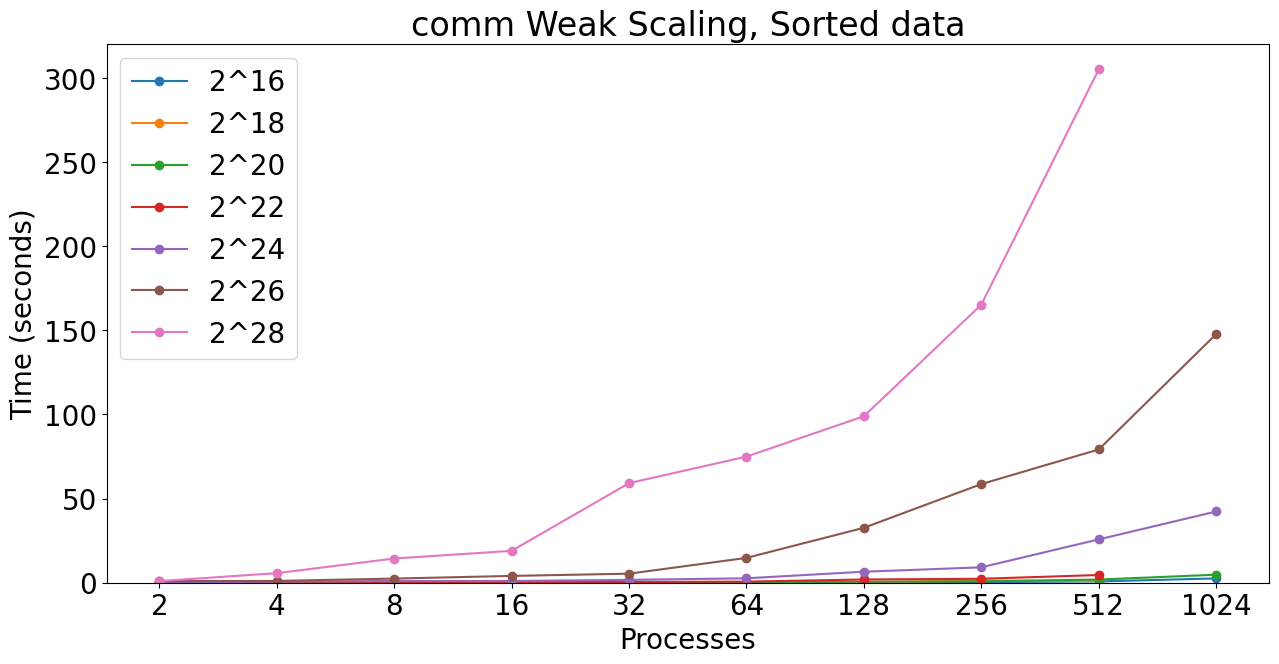

C:\Users\redky\AppData\Local\Temp\ipykernel_42036\2424531023.py:7: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.pivot_table(index = 'input_size', columns='num_procs',values='Avg time/rank', aggfunc = sum)


num_procs          2          4          8         16         32         64  \
input_size                                                                    
65536       0.011889   0.011385   0.011529   0.016915   0.023246   0.046762   
262144      0.004048   0.018360   0.025183   0.035950   0.044957   0.087449   
1048576     0.029338   0.042597   0.065909   0.073675   0.150418   0.306982   
4194304     0.114549   0.168156   0.284390   0.254135   0.405680   1.007897   
16777216    0.686346   1.515133   0.954428   1.199665   1.927472   2.877889   
67108864    1.480372   1.406637   4.000916   5.093202   7.634466  11.462690   
268435456   1.721955  13.157185  17.566819  25.585177  39.068126  65.819860   

num_procs         128         256         512       1024  
input_size                                                
65536        0.152235    0.239748    0.745363   2.572283  
262144       0.214389    1.057587    0.976345   3.026190  
1048576      0.399023    0.847518    1.876812       

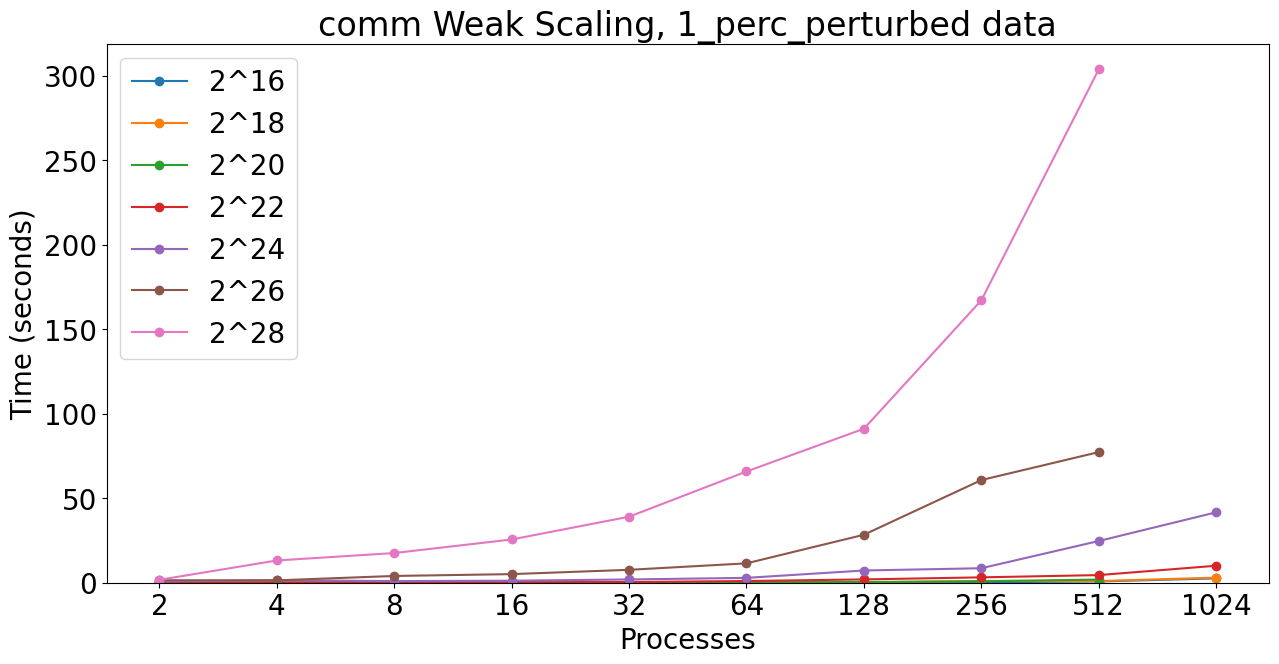

num_procs           2          4          8         16         32         64  \
input_size                                                                     
65536        0.004071   0.010677   0.021494   0.019892   0.041854   0.114930   
262144       0.055921   0.019901   0.031701   0.045577   0.056614   0.121467   
1048576      0.040767   0.044794   0.094176   0.164427   0.204471   0.392656   
4194304      0.131930   0.238788   0.401846   0.565219   0.817205   1.294222   
16777216     0.123510   1.290687   2.216890   2.182338   3.242900   4.385296   
67108864    16.191284   2.152139  11.900082  11.924837  10.606470  20.721441   
268435456    1.650028  92.051966  41.068211  51.822641  64.825310  93.934755   

num_procs          128         256         512       1024  
input_size                                                 
65536         0.145865    0.414781    1.332014   4.991092  
262144        0.241875    0.574180    1.681851   5.583876  
1048576       0.619071    1.074654    2

C:\Users\redky\AppData\Local\Temp\ipykernel_42036\2424531023.py:7: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.pivot_table(index = 'input_size', columns='num_procs',values='Avg time/rank', aggfunc = sum)


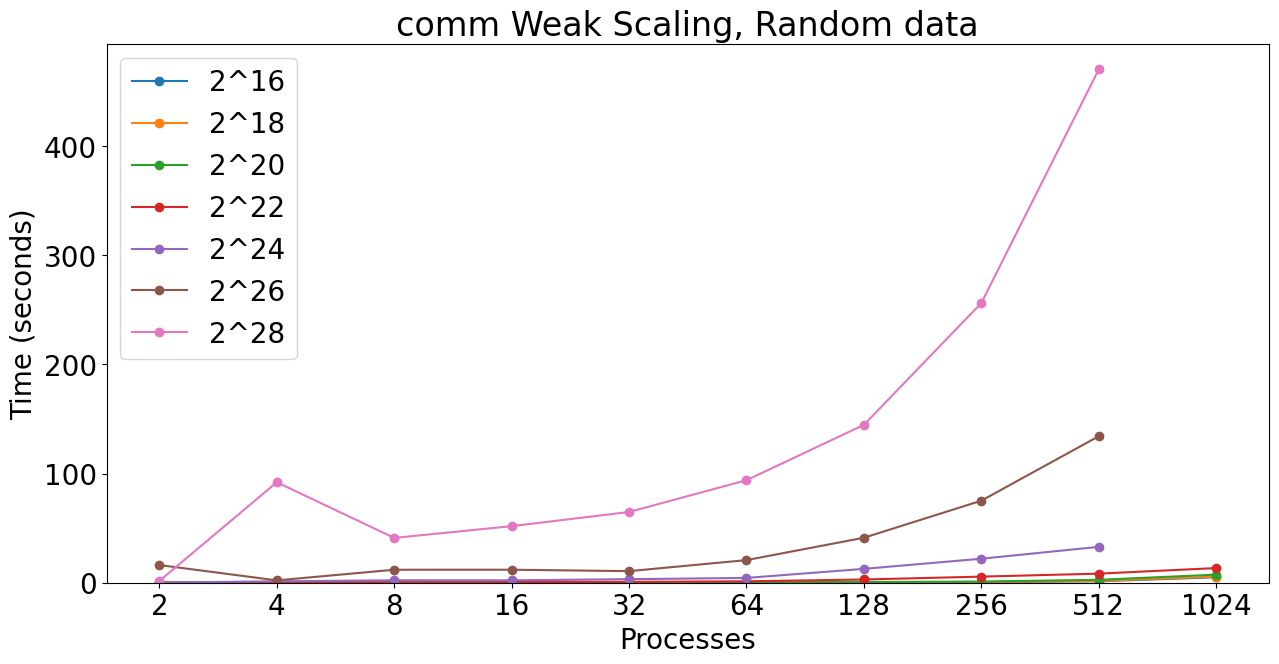

C:\Users\redky\AppData\Local\Temp\ipykernel_42036\2424531023.py:7: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.pivot_table(index = 'input_size', columns='num_procs',values='Avg time/rank', aggfunc = sum)


num_procs          2         4         8         16         32         64  \
input_size                                                                  
65536       0.010454  0.012933  0.012537   0.017325   0.028086   0.052533   
262144      0.012398  0.014242  0.016311   0.028093   0.041550   0.092667   
1048576     0.012810  0.045752  0.053677   0.075525   0.123402   0.164538   
4194304     0.038452  0.096178  0.172077   0.287610   0.400092   0.566445   
16777216    0.159208  0.472595  0.653513   1.101882   1.536820   2.120927   
67108864    0.585109  1.317354  2.419331   3.619907   6.153070   9.479339   
268435456   2.233173  6.386432  8.926353  25.927576  50.047481  79.427882   

num_procs         128         256         512        1024  
input_size                                                 
65536        0.147019    1.068705    0.904042         NaN  
262144       0.207521    0.338275    1.158237         NaN  
1048576      0.498577    1.629346    1.892603    4.226895  
419430

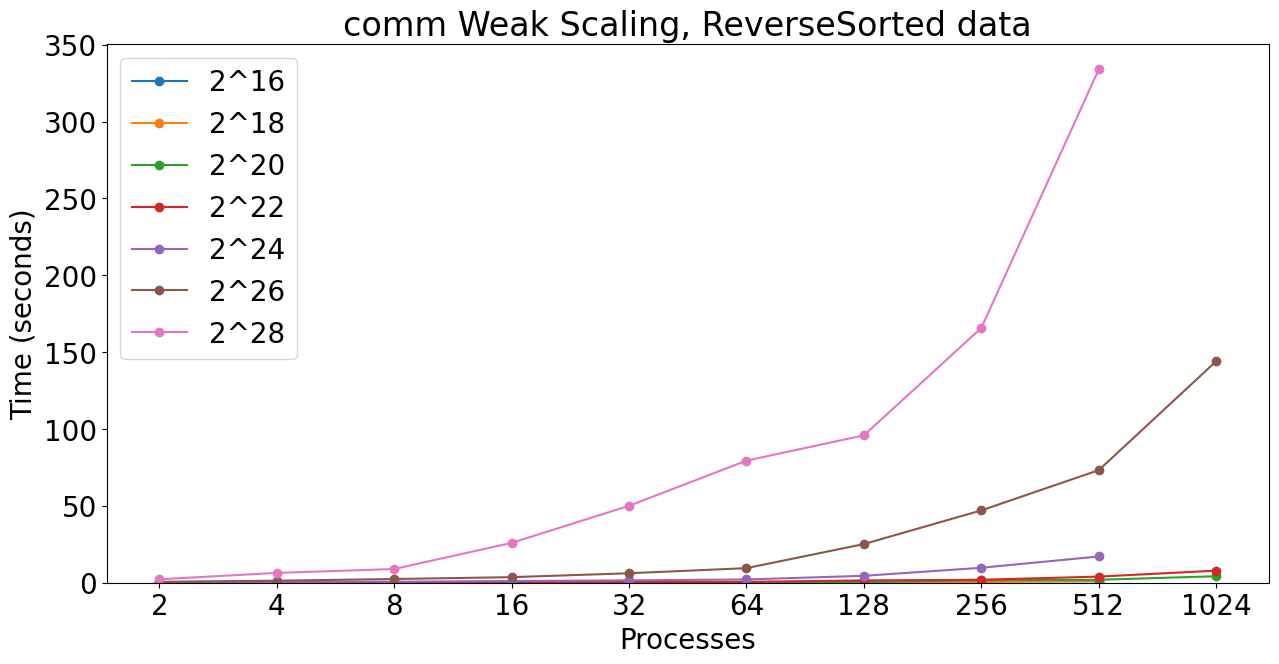

In [181]:

for type in input_types:
    df = tk.dataframe[tk.dataframe["name"] == "comm"]
    df = df[df["input_type"] == type]
    df = df.loc[:, ["Avg time/rank", "num_procs", "input_type"]]

    # print(df)
    df = df.pivot_table(index = 'input_size', columns='num_procs',values='Avg time/rank', aggfunc = sum)
    df = df.replace(f"{type}{type}", "NaN").reset_index().set_index("input_size")
    print(df)
    plot_mpl(
        df.transpose(),
        title = f"comm Weak Scaling, {type} data",
        xlabel="Processes",
        ylabel="Time (seconds)",
    )